In [1]:
!pip install torch torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
#pytorch utility imports
import torch as t #Thêm thư viện pytorch bằng dòng code: import torch
import torchvision #Để sử dụng chuyên biệt cho đọc và xử lý ảnh trên pytorch
import torchvision.transforms as transforms #transforms là các chức năng biến đổi hình ảnh đơn giản có thể được thực hiện theo trình tự ngay sau khi dataset (hình ảnh) được tả
from torchvision import datasets as datasets #load dataset .. từ torchvision.dataset
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn #sẽ sử dụng nó để xây dựng mạng nơ-ron thực tế của mình.
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math

In [ ]:
!pip install https://github.com/ceshine/shap/archive/master.zip

In [51]:
import pandas as pd

path='/content/drive/MyDrive/Bài tập AI/mnist'
pathtrain='/content/drive/MyDrive/Bài tập AI/mnist/train.csv'
pathtest='/content/drive/MyDrive/Bài tập AI/mnist/test.csv'

df_train = pd.read_csv(pathtrain)
df_test = pd.read_csv(pathtest)
print('Train size: ', df_train.shape)
print('Test size: ', df_test.shape)
df_train.head()


Train size:  (42000, 785)
Test size:  (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
#Tính toán trung bình và std của dữ liệu đào tạo - được sử dụng để chuẩn hóa sau này
train_data = df_train.drop('label', axis=1).values
train_mean = train_data.mean()/255.
train_std = train_data.std()/255.
# train_std
print('Mean: ', train_mean)
print('Std: ', train_std)


Mean:  0.13101533792088266
Std:  0.3085401559245608


In [54]:
#Chia dữ liệu đào tạo thành xác thực-đào tạo
# Train-Val split
mask = np.random.rand(len(df_train)) < 0.8
df_val = df_train[~mask]
df_train = df_train[mask]
print('Train size: ', df_train.shape)
print('Val size: ', df_val.shape)
print('Test size: ', df_test.shape)
df_train.head()

Train size:  (33644, 785)
Val size:  (8356, 785)
Test size:  (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, '2')

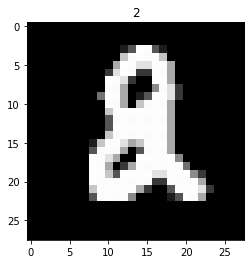

In [55]:
import matplotlib.pyplot as plt
ind = np.random.randint(0, df_train.shape[0]-1)
plt.imshow(df_train.iloc[ind].values[1:].reshape((28,28)), cmap='gray')
plt.title(str(df_train.iloc[ind][0]))


In [ ]:
#Tôi đã sử dụng 3 lớp chuyển đổi cộng với 3 lớp được kết nối đầy đủ với kích hoạt ReLU. Bỏ qua và chuẩn hóa hàng loạt cũng đã được sử dụng.

In [25]:
batch_size = 128
num_epochs = 2 #The number of Epochs is the number of times you go through the full dataset. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class Net(nn.Module):#nn.Modulelà một giao diện cho autograd cung cấp rất nhiều tiện ích trong khi tạo mạng thần kinh.
    def __init__(self):
        super(Net, self).__init__() #

        self.conv_layers = nn.Sequential(
            #Convolutional Layer/Pooling Layer/Activation
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
          #Fully Connected Layer/Activation
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
#Lớp Sequential cho phép chúng ta xây dựng mạng neural PyTorch một cách nhanh chóng mà không cần phải xây dựng một lớp rõ ràng.cho phép chúng ta compose các module với nhau.
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

cpu


In [26]:

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):#same
        data, target = data.to(device), target.to(device)#same
        #xóa gradient cho batch này
        optimizer.zero_grad()
        output = model(data)
        # Tính toán tổn thất Khả năng xảy ra tổn thất log âm. Sẽ rất hữu ích khi đào tạo một bài toán phân loại với các lớp C.
        loss = F.nll_loss(output.log(), target)
        # dloss / dx cho mọi Biến
        loss.backward()
        # để thực hiện cập nhật một bước đối với thông số của chúng tôi.
        optimizer.step()
        #in loss định kỳ
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



In [28]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [29]:


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)



In [30]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)



In [31]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311277
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.282411
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.137242
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.209801
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.814933

Test set: Average loss: 0.0056, Accuracy: 8829/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.786318
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.456023
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.837029
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.472343
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.552609

Test set: Average loss: 0.0027, Accuracy: 9352/10000 (94%)



In [32]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [33]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

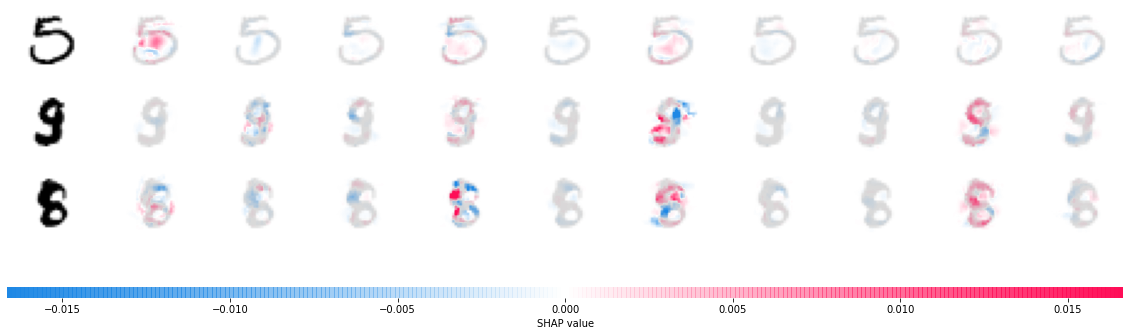

In [59]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)